<a href="https://colab.research.google.com/github/DerekGloudemans/segmentation-medical-images/blob/master/2D_Slice_Segmentation_New_Approaches_with_Mulitclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preliminaries

In [0]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#%%capture 
!pip install -q --upgrade ipython==5.5.0
!pip install -q --upgrade ipykernel==4.6.0
!pip3 install torchvision
!pip3 install opencv-python

import ipywidgets
import traitlets

     |████████████████████████████████| 112kB 3.4MB/s 


In [0]:
# imports

# this seems to be a popular thing to do so I've done it here
#from __future__ import print_function, division


# torch and specific torch packages for convenience
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils import data
from torch import multiprocessing
from google.colab.patches import cv2_imshow

# for convenient data loading, image representation and dataset management
from torchvision import models, transforms
import torchvision.transforms.functional as FT
from PIL import Image, ImageFile, ImageStat
ImageFile.LOAD_TRUNCATED_IMAGES = True
from scipy.ndimage import affine_transform
import cv2

# always good to have
import time
import os
import numpy as np    
import _pickle as pickle
import random
import copy
import matplotlib.pyplot as plt
import math

import nibabel as nib



## Define Dataset for Dealing with NIfTI Files
(1) spleen
(2) right kidney
(3) left kidney
(4) gallbladder
(5) esophagus
(6) liver
(7) stomach
(8) aorta
(9) inferior vena cava
(10) portal vein and splenic vein
(11) pancreas
(12) right adrenal gland
(13) left adrenal gland

In [0]:
class Nifti_Dataset(data.Dataset):
  def __init__(self,mode = "view",dim = 2):
    """
    Save the last 0.15 proportion of files after sorting for use as validation set.
    Loads each slice of the input images as a separate image
    mode - view,train or val, defined in same dataset to maintain data separation
      view - performs transforms but does not normalize images
      train - normalizes data and performs transforms
      val - normalizes data, no augmenting transforms
    dim - specifies dimension along which to slice image
    """

    self.mode = mode
    self.dim = dim

    data_dir = "/content/drive/My Drive/Colab Notebooks/Segmentation/RawData/Training/img"
    label_dir = "/content/drive/My Drive/Colab Notebooks/Segmentation/RawData/Training/label"

    # get all data and label file names
    self.data_files = []
    for file in os.listdir(data_dir):
      self.data_files.append(os.path.join(data_dir,file))
    self.data_files.sort()

    self.label_files = []
    for file in os.listdir(label_dir):
      self.label_files.append(os.path.join(label_dir,file))
    self.label_files.sort()

    # for each data_file
    self.train_data = []
    self.val_data = []

    for i in range(len(self.data_files)):
      data = nib.load(self.data_files[i])
      data = np.array(data.get_fdata())

      label = nib.load(self.label_files[i])
      label = np.array(label.get_fdata()).astype(float)

      identifier = self.data_files[i].split("_")[0]
      for slice in range(0,data.shape[dim]):

        # get slices
        if dim == 0:
          data_slice = data[slice,:,:]
          label_slice = label[slice,:,:]
        elif dim == 1:
          data_slice = data[:,slice,:]
          label_slice = label[:,slice,:]
        elif dim == 2:
          data_slice = data[:,:,slice]
          label_slice = label[:,:,slice]

        mean,std = np.mean(data_slice),np.std(data_slice)
        # define item dict to store info
        item = {
            "identifier":identifier,
            "slice":slice,
            "data":data_slice,
            "label":label_slice,
            "mean":mean,
            "std":std
            }

        # check to make sure this example actually has organs in it
        test = np.bincount(label_slice.astype(int).reshape(-1))
        if len(test) == 1 or test[1] == 0:
          continue

        # assign to either training or validation data
        if i < len(self.data_files) * 0.85:
          self.train_data.append(item)
        else:
          self.val_data.append(item)

      #break # to shorten loading time

    # define some transforms for training dataset
    self.train_transforms = transforms.Compose([
          transforms.ColorJitter(brightness = 0.2,contrast = 0.2,saturation = 0.1),
          transforms.ToTensor(),
          transforms.RandomErasing(p=0.15, scale=(0.04, 0.6), ratio=(0.3, 3.3), value=0, inplace=False), # big
          transforms.RandomErasing(p=0.3, scale=(0.01, 0.3), ratio=(0.3, 3.3), value=0, inplace=False), # medium
          transforms.RandomErasing(p=0.4, scale=(0.005, 0.15), ratio=(0.3, 3.3), value=0, inplace=False),# small
          transforms.RandomErasing(p=0.35, scale=(0.005, 0.2), ratio=(0.3, 3.3), value=0, inplace=False) # small
          

        ])

  def __getitem__(self,index):
      #get relevant dictionary from self memory

      if self.mode in ['train','view']:
        item = self.train_data[index]
      else:
        item = self.val_data[index]

      x = Image.fromarray(item['data']).copy()
      y = Image.fromarray(item['label']).copy()

      # to grayscale
      x  = FT.to_grayscale(x)
      y = FT.to_grayscale(y)

      if self.mode in ['train','view']:
        # randomly flip and rotate both
        FLIP = 0 # np.random.rand()
        if FLIP > 0.5:
          x = FT.hflip(x)
          y = FT.hflip(y)

        ROTATE = np.random.rand()*60 - 30
        x  = x.rotate(ROTATE)
        y = y.rotate(ROTATE,Image.NEAREST)

      # resize to 224 on shorter dimension
      x = FT.resize(x, 256)
      y = FT.resize(y,256,Image.NEAREST)

      if self.mode in ['train','view']:
        # randomly jitter color of data and randomly erase data
        x = self.train_transforms(x)
      # to tensor
      try:
        x = FT.to_tensor(x)
      except:
        pass
      y = FT.to_tensor(y)
            
      # normalize and repeat along color dimension if in train or val mode
      if self.mode in ['train','val']:
        #x = FT.normalize(x,[item['mean']],[item['std']])
        #x = x.repeat(3,1,1)
        pass

      return x,y

  def __len__(self):
    if self.mode in ["train","view"]:
      return len(self.train_data)
    else:
      return len(self.val_data)

  def show(self,index):
    data,label = self[index]
    plt.figure()
    plt.subplot(121)
    data = data.detach()
    plt.imshow(data[0],cmap = "gray")

    plt.subplot(122)
    plt.imshow(label[0],cmap = "gray")
    plt.show()
    # convert each tensor to numpy array

  def show_slices(self,idx = 0,dim = 0,organ_id = None):
    """
    A nice utility function for plotting all of the slices along a given dimension
    idx - indexes all NIfTI images in dataset
    dim - indexes dimension of image
    organ_id - if not None, all other organs removed from label
    """
    data = nib.load(self.data_files[idx])
    label = nib.load(self.label_files[idx])

    data = data.get_fdata()
    data = np.array(data)
    label = label.get_fdata()
    label = np.array(label)

    for slice in range(0,data.shape[dim]):
      if dim == 0:
            data_slice = data[slice,:,:]
            label_slice = label[slice,:,:]
      elif dim == 1:
        data_slice = data[:,slice,:]
        label_slice = label[:,slice,:]
      elif dim == 2:
        data_slice = data[:,:,slice]
        label_slice = label[:,:,slice]

      if organ_id is not None:
        # if a specific label is to be looked at, 0 all others
        label_slice = 1.0 - np.ceil(np.abs(label_slice.astype(float)-organ_id)/15.0)

      print(np.unique(label_slice))
      plt.figure()
      plt.subplot(121)
      plt.imshow(data_slice,cmap = "gray")

      plt.subplot(122)
      plt.imshow(label_slice,cmap = "gray")
      plt.show()

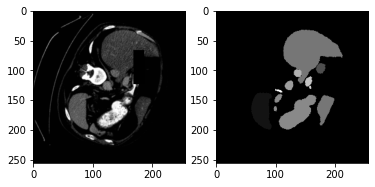

774

In [0]:
dataset = Nifti_Dataset(mode = "train",dim = 2)
idx = np.random.randint(0,len(dataset))
dataset.show(idx)
len(dataset)
#dataset.show_slices(0,dim = 2, organ_id = None)

## Define UNet

Use model from github, and define so it outputs one plane for each organ class

In [0]:
class UNet(nn.Module):
    def __init__(
        self,
        in_channels=1,
        n_classes=14,
        depth=4,
        wf=5,
        padding=True,
        batch_norm=False,
        up_mode='upconv',
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

        innum = 1000
        midnum = 100
        outnum = 4*n_classes
        self.reg = nn.Sequential(
            nn.BatchNorm1d(innum),
            nn.Linear(innum,midnum),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(midnum,outnum),
            nn.Sigmoid()
        )
        self.soft2d = nn.Softmax2d()
        #for param in self.parameters():
        #  param.requires_grad = True

    def forward(self, x,BBOX = False):
        blocks = []
        
        # encoder
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        # do bbox regression here
        if BBOX:
          x_reg = x.view(-1)
          x_reg = self.reg(x_reg)
          bboxes = x_reg.view(4,-1)

        # decoder
        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        #CHANGE THIS LINE FOR MULTIPLE OUTPUT CHANNELS
        # apply per_class last layer and per-class Softmax 
        #x = self.soft2d(self.last(x)) 
        x = torch.sigmoid(self.last(x))
        
        if BBOX:
          return x, bboxes
        else:
          return x


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

## Define Assorted Functions for Training and Testing

Critical to realize here is that we can either define a UNet that has 1 output channel (positive negative) or 13 output channels (each class). For now, we'll start with just one output map, and see where that gets us

In [0]:
def refactor_inputs(x,y,mode = "all_organs",id_num = 1,num_outputs = 13):
  """
  Modifies inputs for different segmentation-style tasks with the goal of training
  the same network for progressively more difficult tasks
  mode - foreground,all_organs,edges,organ_slices, bboxes 
  x - batch x 1 x 256x256 image
  y - batch x 1 x 256 x 256 image with integer value classes
  id_num - int - specifies organ to look for for single organ mode
  num_outputs - specifies number of output maps to make
  """
  ones = torch.ones(y.shape)
  zeros = torch.zeros(y.shape)
  y = (y/0.0039).floor()

  if mode == "foreground":
    # all foreground is 1, everything else is 0
    # all slices but first share same info
    threshold = x.mean()
    y1 = torch.where(x > threshold,ones,zeros)
    # fills all labeled areas with ones as well
    y1 = torch.where(y>0,ones,y1)
    target = y1.repeat(1,num_outputs,1,1)

  elif mode == "all_organs":
    # all organs are one, everything else is 0
    positive_class = 0
    y1 = torch.where(y > 0,ones, zeros)
    # get same map for each class
    target = y1.repeat(1,num_outputs,1,1)

  elif mode == "single_organ":
    # all slices contain same map (positive for a single organ)
    y1 = torch.where((y.int() == id_num),ones,zeros)
    target = y1#.repeat(1,num_outputs,1,1)

  elif mode == "organ_slices":
    all_slices = []
    for i in range(0,num_outputs+1):
      y1 = torch.where((y.int() == i),ones,zeros)
      all_slices.append(y1)
    target = torch.cat(all_slices,dim = 1)

  elif mode == "bboxes":
    pass   
  elif mode == "edges":
    pass # apply edge filter
  
    pass
   
  return x,target

def test_slice(dataset,model,idx,device,refactor_mode):
  x,y = dataset[idx]
  x = x.unsqueeze(0)
  y = y.unsqueeze(0)

  x,y_new = refactor_inputs(x,y,mode = refactor_mode)
  x = x.to(device)

  output = model(x)
  #if refactor_mode == "organ_slices":
  #  output = F.softmax(output,dim = 1)
  output = output.cpu()
  output = output.data.numpy()
  
  # inputs
  plt.figure(figsize = (10,10))
  plt.subplot(221)
  plt.title("Inputs")
  plt.imshow(x.data.cpu().numpy()[0][0],cmap = "gray")
  plt.clim(0,1)

  # original labels
  plt.subplot(222)
  plt.imshow(y[0][0],cmap = "gray")
  plt.title("Original Labels")


  # stack outputs if mode == organ_slices
  if refactor_mode == "organ_slices":
    output = output[0]
    
    stacked = torch.zeros((output[0].shape))
    for i in range(0,len(output)):
      stacked += output[i]*(i)
      print(output[i].mean())
    output = stacked
  else:
    output = output[0][0]
  
  # outputs
  plt.subplot(223)
  plt.imshow(output,cmap = "gray")
  plt.clim(0,13)
  plt.title("Outputs")
 
  # stack new_labels if mode == organ_slices
  if refactor_mode == "organ_slices":
    y_new = y_new[0]
    stacked = torch.zeros((y_new[0].shape))
    for i in range(0,len(y_new)):
      stacked += y_new[i]*(i)

    y_new = stacked
  else:
    y_new = y_new[0][0]

  # binary target
  plt.subplot(224)
  plt.imshow(y_new,cmap = "gray")
  plt.title("Correct Labels")
  plt.clim(0,13)
  plt.show()


class Dice_Loss(nn.Module):        
    def __init__(self):
        super(Dice_Loss,self).__init__()
        
    def forward(self,output,target,epsilon = 1e-07):
        """ Compute the bbox iou loss for target vs output using tensors to preserve
        gradients for efficient backpropogation"""
        numerator = 2.0*torch.mul(output,target) 
        denominator = output + target
        dice = torch.div(numerator,denominator)
        #print (dice.shape)
        #loss =  1.0 -(torch.sum(dice)/torch.numel(dice))
        #print("{} / {} = {}".format(numerator.sum(),denominator.sum(),loss))

        loss = 1.0 - torch.sum(numerator)/torch.sum(denominator)
        #print (loss.shape)
        #print (loss)
        return loss

def load_model(checkpoint_file,model,optimizer):
  """
  Reloads a checkpoint, loading the model and optimizer state_dicts and 
  setting the start epoch
  """
  checkpoint = torch.load(checkpoint_file)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  all_losses = checkpoint['losses']
  all_accs = checkpoint['accs']

class Sparse_Loss(nn.Module):        
    def __init__(self):
        super(Sparse_Loss,self).__init__()
        self.relu = nn.ReLU()
   
    def forward(self,output):  
        buffered = output#-0.01
        penalty = self.relu(buffered)
        return penalty.mean()

def load_model(checkpoint_file,model,optimizer):
  """
  Reloads a checkpoint, loading the model and optimizer state_dicts and 
  setting the start epoch
  """
  checkpoint = torch.load(checkpoint_file)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  all_losses = checkpoint['losses']
  all_accs = checkpoint['accs']

  return model,optimizer,epoch,all_losses,all_accs

## Basic Training Loop
All special modifications should be done by means of refactor_inputs

In [0]:
#idx = random.randint(0,len(dataset))
#test_slice(dataset,model,idx,device,"organ_slices")

##test = torch.Tensor([[1,2,4],[3,2,6]])
#out = torch.where(test == 2,torch.ones(test.shape),torch.zeros(test.shape))
#print (out)

In [0]:
def train_model(model, optimizer, scheduler,loss_function,loss_function2,
                    dataset,device, num_epochs=5, start_epoch = 0,
                    all_losses = None,all_accs = None,refactor_mode = "foreground"):
        """
        Alternates between a training step and a validation step at each epoch. 
        Validation results are reported but don't impact model weights
        """
        loss3 = Sparse_Loss()

        # define once storing all metrics
        if all_losses == None:
          all_losses = {
                  'train':[],
                  'val':[]
          }
          all_accs = {
                  "train":[],
                  "val":[]
                  }
        avg_acc = 0
        
        # create testloader for val_dataset (loader is made each epoch)
        params = {'batch_size': 8,
              'shuffle': True,
              'num_workers': 0,
              'drop_last' : True
              }

        # One epoch covers all data once
        for epoch in range(start_epoch,num_epochs):
            print("")

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                
                if phase == 'train':
                  # Set model to training mode
                  model.train()
                  # Step scheduler  
                  if epoch > 0:
                    scheduler.step(avg_acc)
                  # set dataset and dataloader to training mode
                  dataset.mode = "train"
                  loader = data.DataLoader(dataset,**params)
                    
                elif phase == "val":
                  model.eval()   # Set model to evaluate mode
                  dataset.mode = "val"
                  loader = data.DataLoader(dataset,**params)

                # metrics summaries per epoch
                count = 0
                total_loss = 0
                total_acc = 0

                # Iterate over each data item                                                        
                for input, target in loader:

                    input,target = refactor_inputs(input,target,mode = refactor_mode,id_num = 1)

                    input = input.to(device)
                    target = target.to(device)
                    
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                      output = model(input)

                      # to prevent overlearning negatives
                      output = output[:,1:,:,:]
                      target = target[:,1:,:,:]
                      ones = torch.ones((output.shape)).to(device)
                      zeros = torch.zeros((output.shape)).to(device)
                      # get loss and accuracy
                      loss = loss_function(output.float(),target.float())
                      acc = 1.0 - loss
                      for i in range(0,len(output[1])):
                        loss = loss + loss_function2(output[:,i,:,:].float(),target[:,i,:,:].float())
                      loss = loss + 3*loss3(output)
                      #backprop loss
                      if phase == 'train':
                          loss.backward()
                         
                          #print(model.up_path[0].conv_block.block[0].weight.grad[0])
                          #print("Example Gradient: {}".format(model.conv.weight.grad[0][0]))
                          #for param in model.parameters():
                            #print (param.grad)
                          optimizer.step()
                    
                    # verbose update
                    count += 1
                    total_acc += acc
                    total_loss += loss.item()
                    if count % 20 == 0:
                      print("{} epoch {} batch {} -- Loss: {:03f} -- Accuracy {:02f}".format(phase,epoch,count,loss.item(),acc))
                
                avg_acc = total_acc/count
                avg_loss = total_loss/count
                print("Epoch {} avg {} loss: {:05f}  acc: {}".format(epoch, phase,avg_loss,avg_acc))
                all_losses[phase].append(total_loss)
                all_accs[phase].append(avg_acc)

                if epoch % 1 == 0:
                  
                  # plot an output
                  idx = np.random.randint(0,len(dataset))
                  try:
                    test_slice(dataset,model,idx,device,refactor_mode)
                  except:
                    pass

                  # save a checkpoint
                  PATH = "/content/drive/My Drive/Colab Notebooks/Segmentation/checkpoints/UNet_{}.pt".format(epoch)
                  torch.save({
                      'epoch': epoch,
                      'model_state_dict': model.state_dict(),
                      'optimizer_state_dict': optimizer.state_dict(),
                      "losses":all_losses,
                      "accs":all_accs
                      }, PATH)
                  
                torch.cuda.empty_cache()
                del loader
                
        return model , all_losses,all_accs

## Run Training Loop

Model loaded.
Reloaded checkpoint /content/drive/My Drive/Colab Notebooks/Segmentation/checkpoints/UNET114_slices_e19.pt.
Beginning training on cuda:0.

train epoch 0 batch 20 -- Loss: 1.596508 -- Accuracy 0.124788
train epoch 0 batch 40 -- Loss: 1.435913 -- Accuracy 0.176288
train epoch 0 batch 60 -- Loss: 1.390579 -- Accuracy 0.167909
train epoch 0 batch 80 -- Loss: 1.276604 -- Accuracy 0.271757
Epoch 0 avg train loss: 1.545281  acc: 0.18917229771614075
0.99992573
0.016475126
0.0011920772
0.0018437859
0.00053830293
0.0003116135
0.26502743
0.009160376
0.000982921
0.0010166398
0.00076123
0.0013943609
0.00026646093
0.00032489927


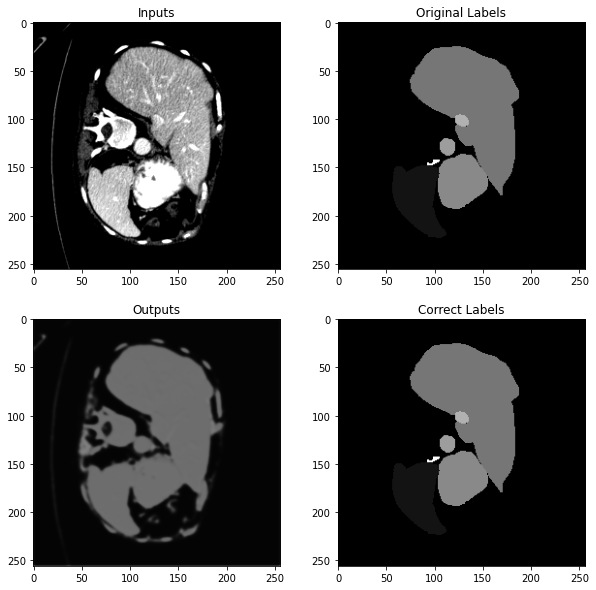

Epoch 0 avg val loss: 1.240177  acc: 0.34791722893714905
0.99987596
0.014883008
0.0014363012
0.0022771799
0.00083095947
0.0004655648
0.14762469
0.009796517
0.0012660766
0.0012626554
0.00097405293
0.0017936626
0.0004035622
0.00048664233


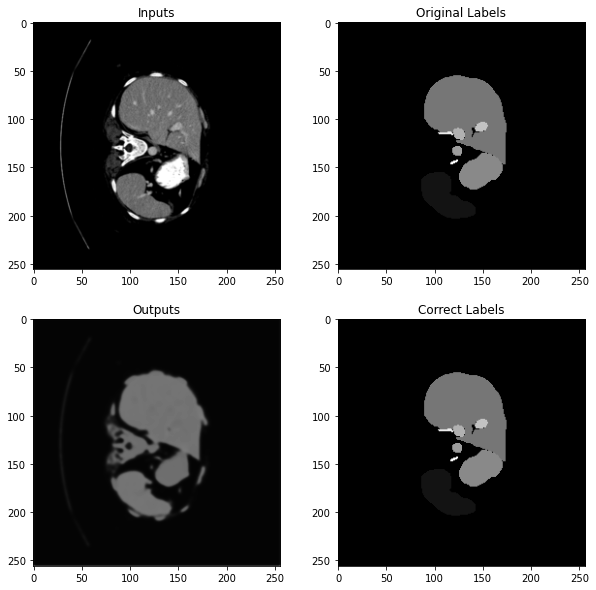


train epoch 1 batch 20 -- Loss: 1.358586 -- Accuracy 0.301582
train epoch 1 batch 40 -- Loss: 1.465970 -- Accuracy 0.262254
train epoch 1 batch 60 -- Loss: 1.303513 -- Accuracy 0.242159
train epoch 1 batch 80 -- Loss: 1.193165 -- Accuracy 0.323342
Epoch 1 avg train loss: 1.278217  acc: 0.30548152327537537
0.99990743
0.0064658253
0.0015397836
0.0016209545
0.00041898395
0.0002744108
0.020718867
0.008059082
0.0010133189
0.0012659138
0.0009369041
0.0017564086
0.0002089545
0.00024922844


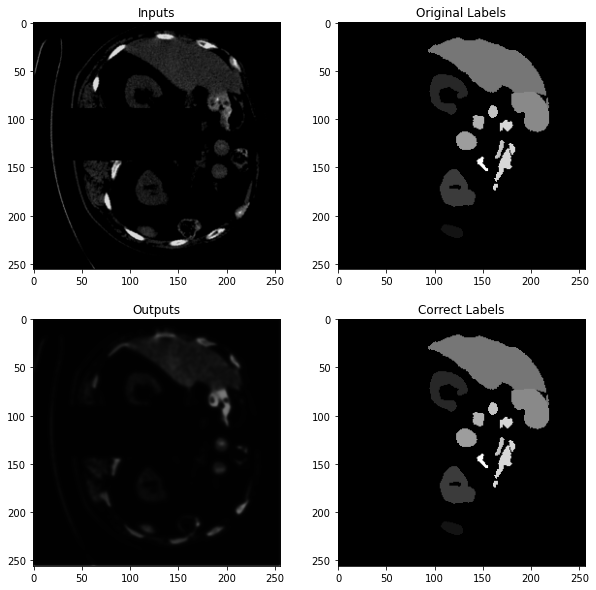

Epoch 1 avg val loss: 1.083857  acc: 0.3835206925868988
0.9997965
0.014836586
0.0019715987
0.0025679383
0.00082799117
0.0005258461
0.07161904
0.009573948
0.0014924915
0.0016791243
0.001357427
0.00234167
0.0004147984
0.00046248164


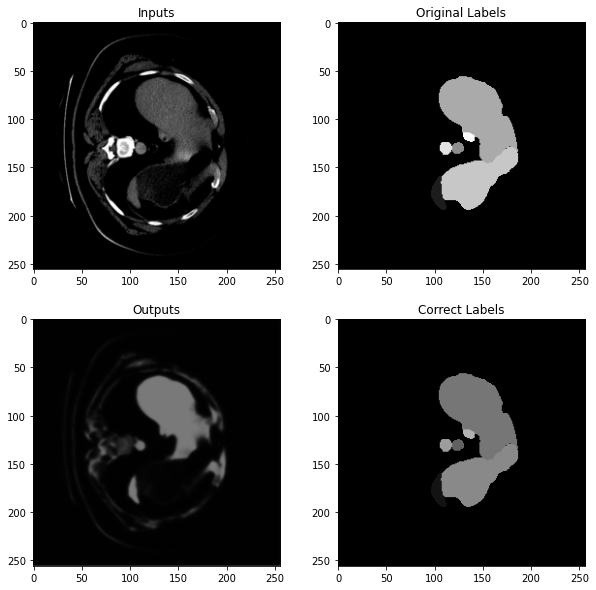


train epoch 2 batch 20 -- Loss: 1.118781 -- Accuracy 0.431270
train epoch 2 batch 40 -- Loss: 1.471341 -- Accuracy 0.231392
train epoch 2 batch 60 -- Loss: 1.228586 -- Accuracy 0.249856
train epoch 2 batch 80 -- Loss: 1.149588 -- Accuracy 0.397243
Epoch 2 avg train loss: 1.265194  acc: 0.3149054944515228
0.99990916
0.00743217
0.00087720016
0.0011024298
0.00034959672
0.0001883188
0.033996683
0.008129378
0.0006976143
0.0007969213
0.0005882726
0.0008763803
0.00014305368
0.00016677592


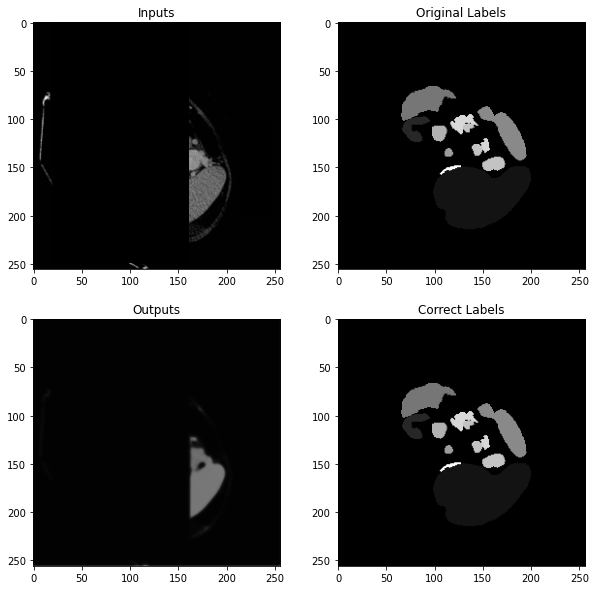

Epoch 2 avg val loss: 1.066306  acc: 0.41785454750061035
0.99969524
0.025119511
0.0020088367
0.0029188779
0.001005019
0.0005596089
0.14273939
0.01324622
0.0017161923
0.0018898661
0.0014780168
0.0021139965
0.0004538242
0.00050303794


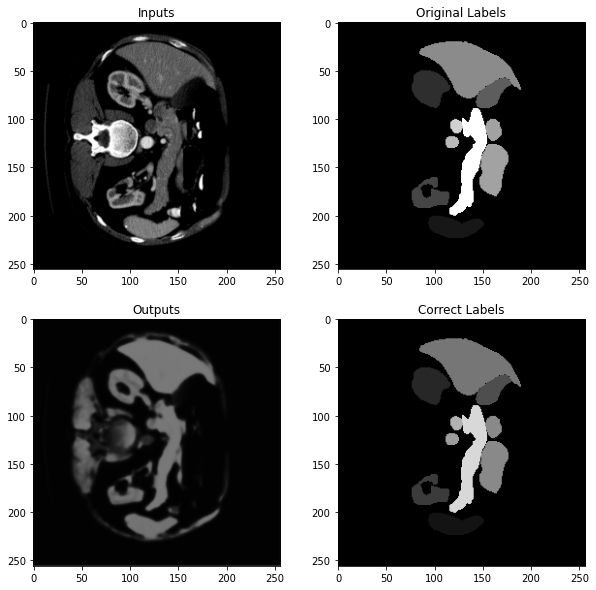


train epoch 3 batch 20 -- Loss: 1.401703 -- Accuracy 0.231374
train epoch 3 batch 40 -- Loss: 1.351440 -- Accuracy 0.262894
train epoch 3 batch 60 -- Loss: 1.072506 -- Accuracy 0.474503
train epoch 3 batch 80 -- Loss: 1.211983 -- Accuracy 0.369671
Epoch 3 avg train loss: 1.233681  acc: 0.3338319659233093
0.9997824
0.014704049
0.0014383864
0.0019819345
0.0006159696
0.00031561404
0.10309197
0.009062282
0.001143162
0.0013458254
0.0009819812
0.0014907725
0.0002500381
0.00028754817


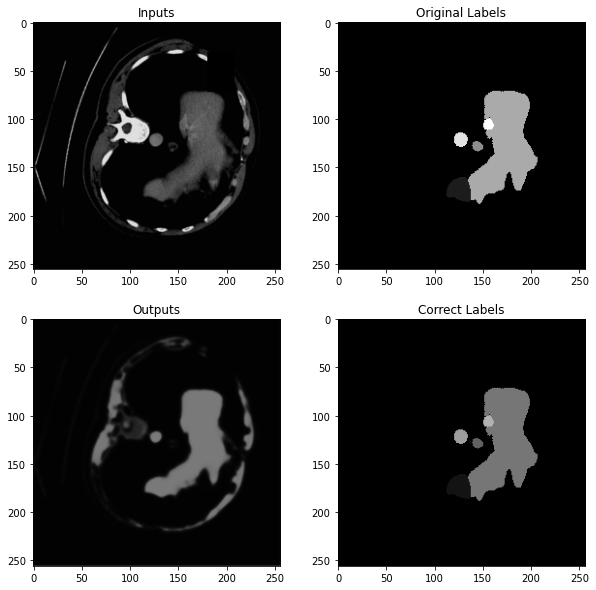

Epoch 3 avg val loss: 1.109734  acc: 0.42920202016830444
0.9998251
0.0146199595
0.0012091978
0.0016837941
0.00050603435
0.00026230252
0.09872326
0.007917827
0.0009405518
0.0011022587
0.00081279775
0.0012254479
0.00020072679
0.0002369824


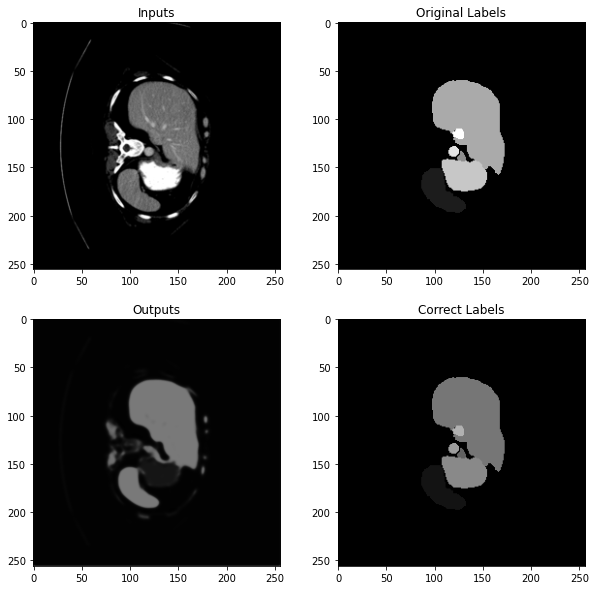


train epoch 4 batch 20 -- Loss: 1.299858 -- Accuracy 0.297335
train epoch 4 batch 40 -- Loss: 1.058429 -- Accuracy 0.384829
train epoch 4 batch 60 -- Loss: 1.622181 -- Accuracy 0.151133
train epoch 4 batch 80 -- Loss: 0.968073 -- Accuracy 0.479266
Epoch 4 avg train loss: 1.226307  acc: 0.33825308084487915
0.9998327
0.008212837
0.0009853435
0.0013143308
0.00045109217
0.00020465437
0.04130828
0.008461392
0.00088586146
0.0009450136
0.00070711406
0.0011779852
0.00016466538
0.00019123194


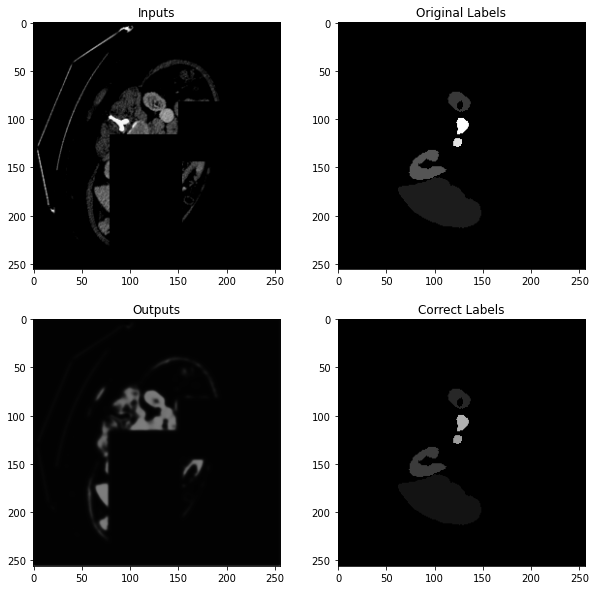

Epoch 4 avg val loss: 1.112728  acc: 0.4090031683444977
0.9994851
0.037965093
0.0022563837
0.0031986749
0.0009816532
0.0005622313
0.18551081
0.0132109355
0.0018818958
0.0023057647
0.0016520463
0.0025564665
0.00046411372
0.0005133422


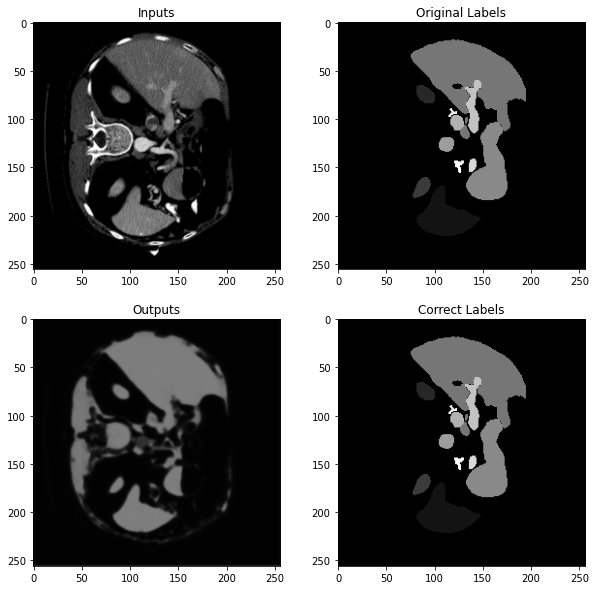


train epoch 5 batch 20 -- Loss: 1.285278 -- Accuracy 0.347156
train epoch 5 batch 40 -- Loss: 1.197095 -- Accuracy 0.339655
train epoch 5 batch 60 -- Loss: 1.143330 -- Accuracy 0.367097
train epoch 5 batch 80 -- Loss: 1.039964 -- Accuracy 0.449172
Epoch 5 avg train loss: 1.222597  acc: 0.342342734336853
0.99987376
0.006046568
0.00067241024
0.00091499626
0.00029615458
0.00012900948
0.028235445
0.0045705093
0.0005358272
0.0006017124
0.00045160705
0.00067954004
0.00010232409
0.00011773533


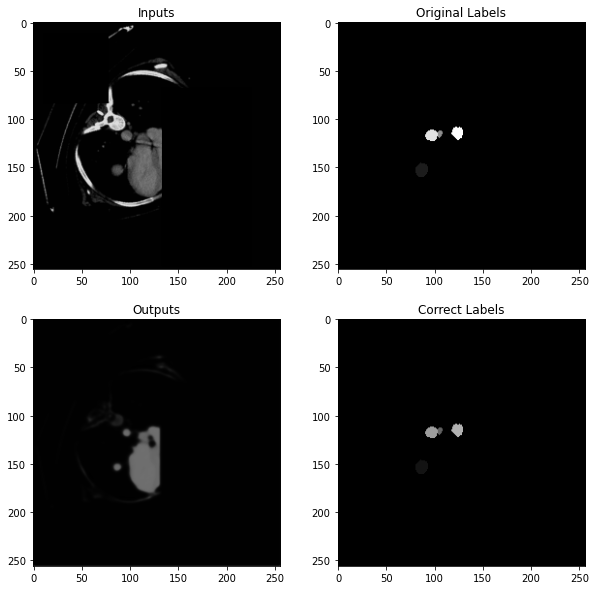

Epoch 5 avg val loss: 1.040384  acc: 0.4227484166622162
0.999549
0.028041193
0.0018783524
0.002591751
0.0007147334
0.00039485196
0.17533246
0.008212194
0.0013581268
0.0018476546
0.0012720713
0.0018818125
0.000339733
0.00036320655


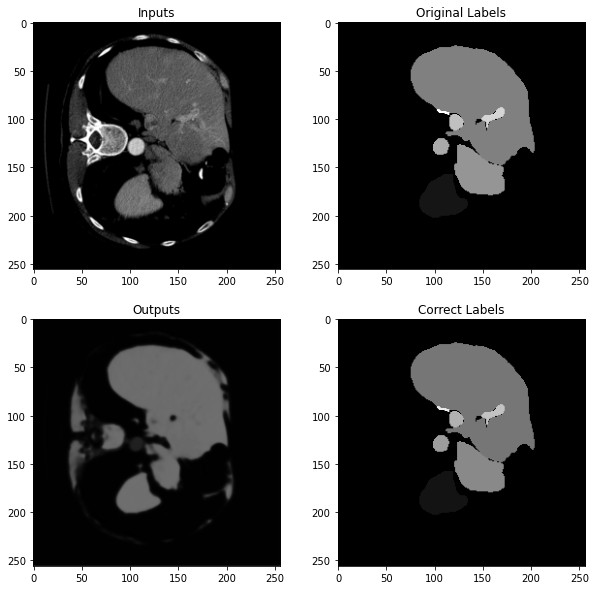


train epoch 6 batch 20 -- Loss: 1.279491 -- Accuracy 0.372061
train epoch 6 batch 40 -- Loss: 1.121520 -- Accuracy 0.419976
train epoch 6 batch 60 -- Loss: 1.165719 -- Accuracy 0.407038
train epoch 6 batch 80 -- Loss: 1.185702 -- Accuracy 0.387909
Epoch 6 avg train loss: 1.215278  acc: 0.3456326425075531
0.99973357
0.01577764
0.0011286326
0.0016130742
0.00040414912
0.00020162493
0.14879142
0.0071827085
0.0008609866
0.0010910255
0.00078436814
0.0011732603
0.00016908636
0.00018980543


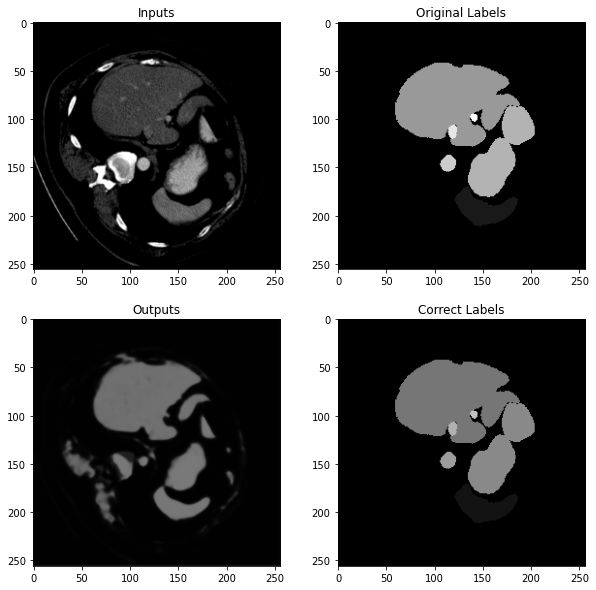

Epoch 6 avg val loss: 1.083631  acc: 0.44025129079818726
0.9996864
0.020500928
0.0013374381
0.0019534756
0.000462152
0.00024516002
0.16328727
0.007907957
0.0009762371
0.001248871
0.000909103
0.0013332742
0.00020239416
0.00023065675


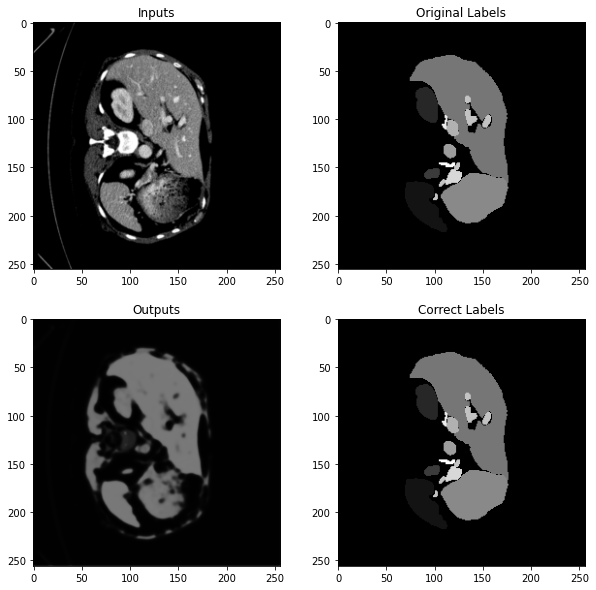


train epoch 7 batch 20 -- Loss: 1.323085 -- Accuracy 0.334608
train epoch 7 batch 40 -- Loss: 1.090053 -- Accuracy 0.244602
train epoch 7 batch 60 -- Loss: 1.174324 -- Accuracy 0.379742
train epoch 7 batch 80 -- Loss: 1.184220 -- Accuracy 0.322464
Epoch 7 avg train loss: 1.189846  acc: 0.3597823977470398
0.9996381
0.008792872
0.0016505816
0.0020902944
0.0007231313
0.0003120401
0.068755865
0.010249381
0.0011896227
0.0013408541
0.001144053
0.0017209476
0.00026442023
0.0003078605


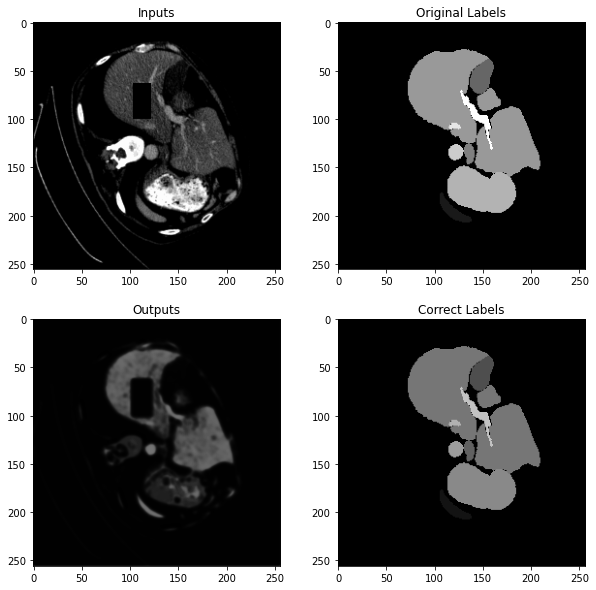

Epoch 7 avg val loss: 1.027686  acc: 0.433799147605896
0.99974155
0.009161387
0.001179056
0.0015106455
0.00045477948
0.0002069666
0.06693964
0.0076042293
0.00080069486
0.00097456644
0.0007828273
0.0011996453
0.00016904702
0.00019785759


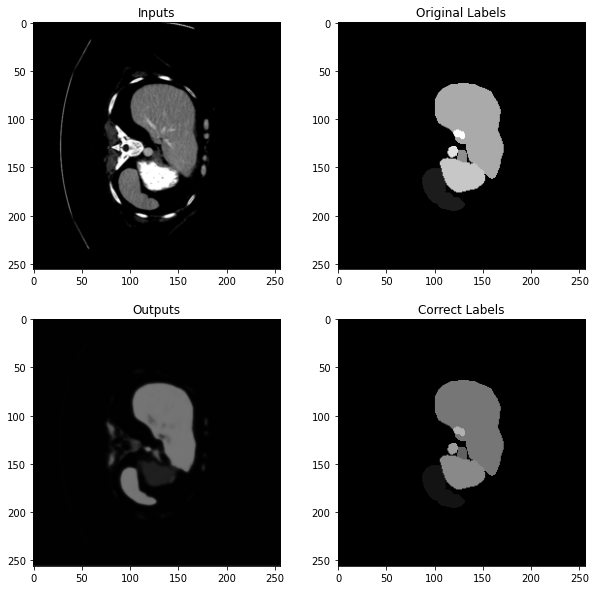


train epoch 8 batch 20 -- Loss: 1.352045 -- Accuracy 0.239868
train epoch 8 batch 40 -- Loss: 1.254452 -- Accuracy 0.283860
train epoch 8 batch 60 -- Loss: 1.094779 -- Accuracy 0.326120
train epoch 8 batch 80 -- Loss: 1.221907 -- Accuracy 0.312530
Epoch 8 avg train loss: 1.188784  acc: 0.36153560876846313
0.9996581
0.009889393
0.0013876355
0.0020327545
0.0006214912
0.0002591965
0.056351986
0.013754804
0.001108336
0.0011811282
0.0010065077
0.0015173437
0.00021654667
0.00025923687


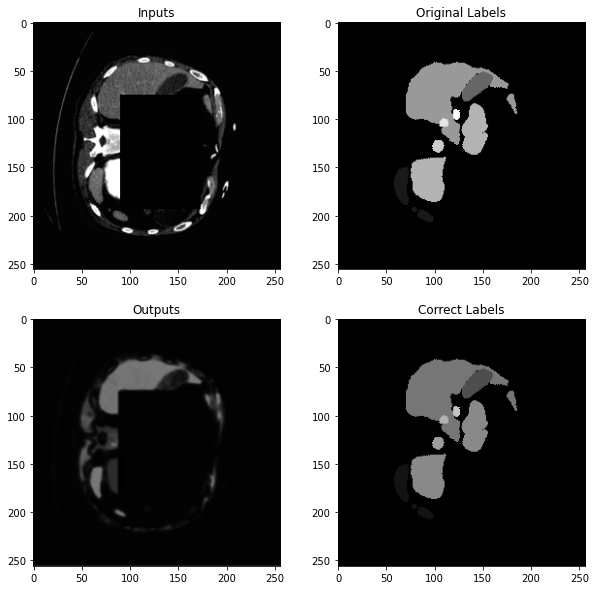

Epoch 8 avg val loss: 1.039242  acc: 0.4237779378890991
0.9994325
0.024434214
0.0021077194
0.0030759263
0.00076945475
0.00039094916
0.1409576
0.015057841
0.0015338747
0.001938019
0.001466492
0.0022535382
0.00033785464
0.0003837765


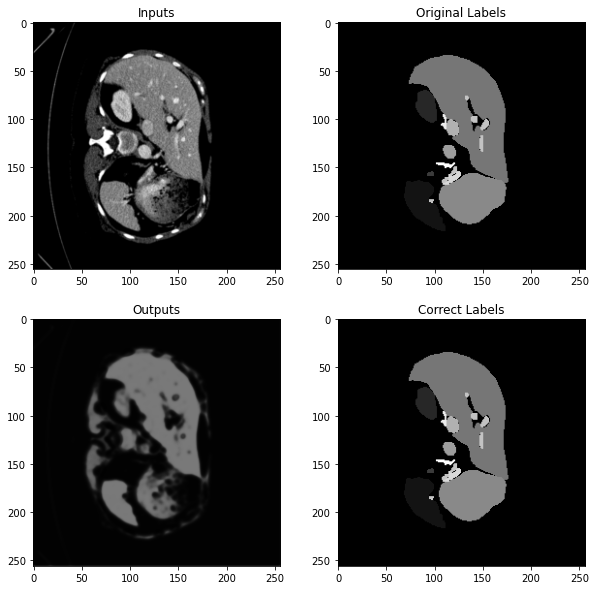


train epoch 9 batch 20 -- Loss: 1.125723 -- Accuracy 0.413417
train epoch 9 batch 40 -- Loss: 0.942337 -- Accuracy 0.468219
train epoch 9 batch 60 -- Loss: 1.161783 -- Accuracy 0.280872
train epoch 9 batch 80 -- Loss: 1.098729 -- Accuracy 0.351614
Epoch 9 avg train loss: 1.193353  acc: 0.3589177131652832
0.99965066
0.014179896
0.0012907585
0.0018123501
0.00044171623
0.00019657622
0.10737599
0.008706294
0.00089741475
0.0011557573
0.0008199852
0.0013267914
0.00016416167
0.00018888032


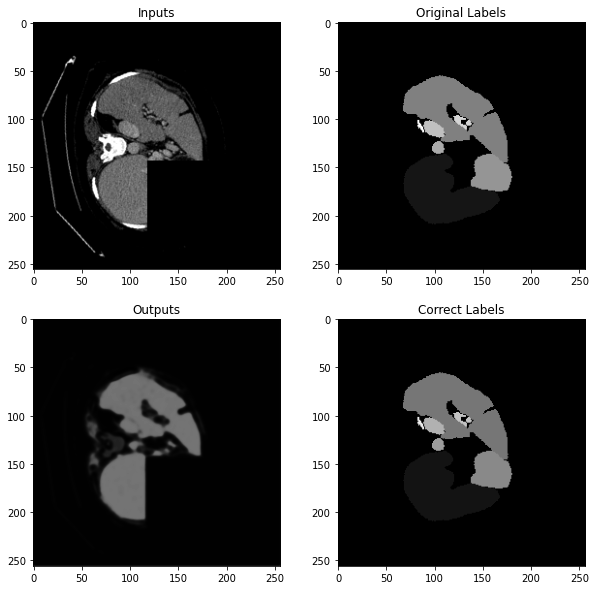

Epoch 9 avg val loss: 1.023384  acc: 0.441506564617157
0.99963886
0.013726114
0.0013935713
0.0019656457
0.0004909963
0.00021584405
0.09746793
0.00941388
0.00097508915
0.0011939793
0.0008903353
0.0014002719
0.0001817887
0.00021073499


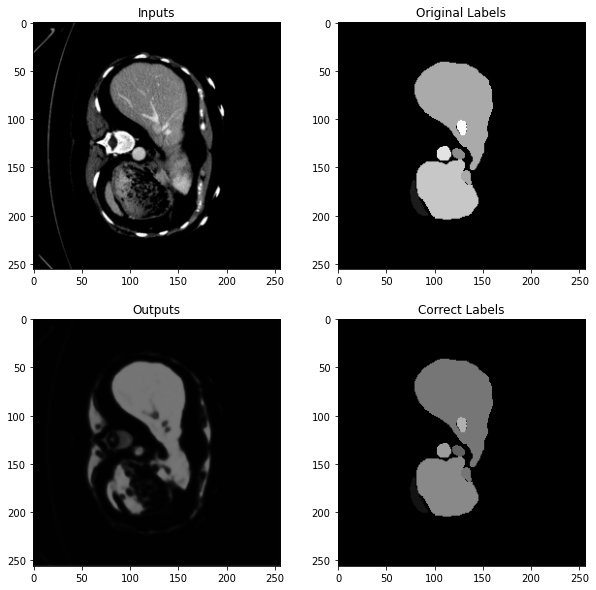


train epoch 10 batch 20 -- Loss: 1.203020 -- Accuracy 0.303337
train epoch 10 batch 40 -- Loss: 1.290970 -- Accuracy 0.296740
train epoch 10 batch 60 -- Loss: 1.053553 -- Accuracy 0.492478
train epoch 10 batch 80 -- Loss: 1.329813 -- Accuracy 0.233479
Epoch 10 avg train loss: 1.199216  acc: 0.3553001284599304
0.999538
0.016357522
0.0015299588
0.0021195675
0.0005928709
0.00025256455
0.10377124
0.010840171
0.0011774723
0.001402049
0.0010064312
0.0016864046
0.0002062142
0.00024606445


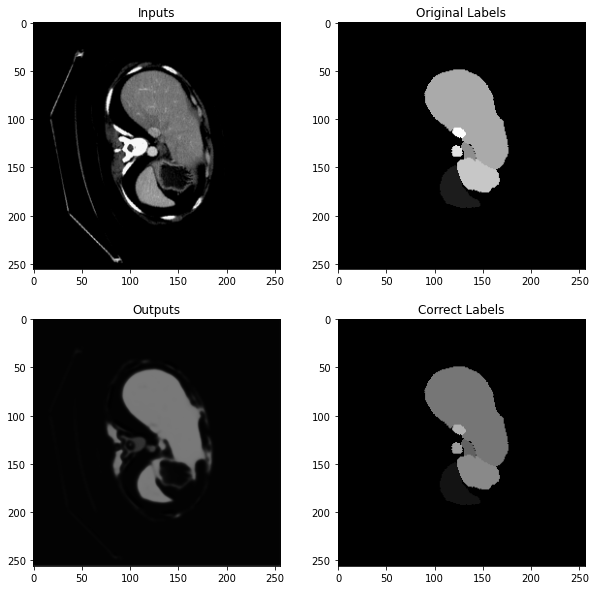

Epoch 10 avg val loss: 1.074172  acc: 0.4229707419872284
0.9994607
0.01802058
0.0016847285
0.0022799303
0.0006563755
0.00028222866
0.12913707
0.010996969
0.0013115461
0.0016232245
0.0011198312
0.0019247893
0.0002335579
0.00027151871


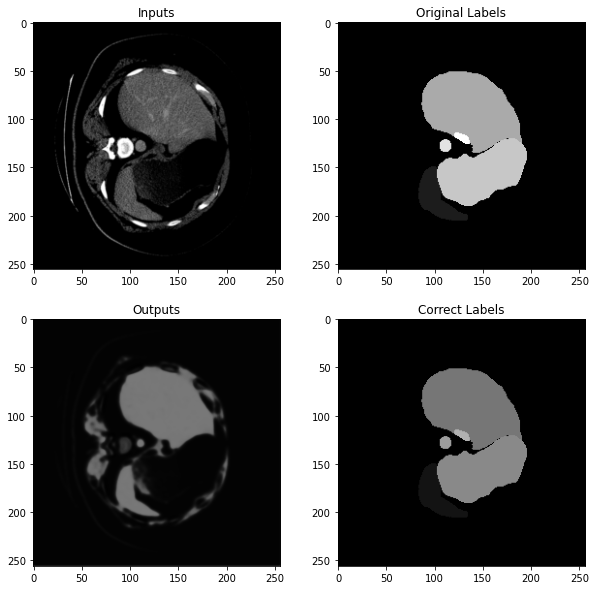


train epoch 11 batch 20 -- Loss: 1.369916 -- Accuracy 0.295464
train epoch 11 batch 40 -- Loss: 1.130202 -- Accuracy 0.351857
train epoch 11 batch 60 -- Loss: 0.916662 -- Accuracy 0.463242
train epoch 11 batch 80 -- Loss: 1.249036 -- Accuracy 0.399203
Epoch 11 avg train loss: 1.172161  acc: 0.3692973852157593
0.99980265
0.0032435034
0.00062770676
0.0008322885
0.00029098368
9.832777e-05
0.013906285
0.0062049553
0.00053296896
0.00052370445
0.000420812
0.0007578255
7.6460965e-05
9.3132854e-05


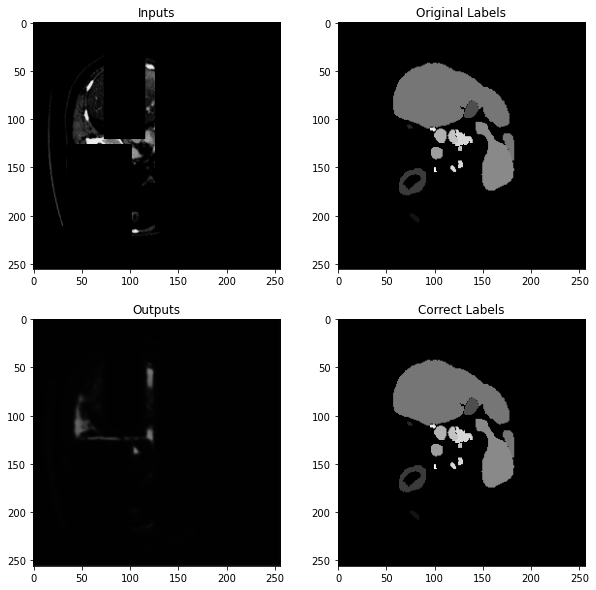

Epoch 11 avg val loss: 1.053387  acc: 0.44031742215156555
0.99944437
0.021792976
0.0015663579
0.0021204653
0.0005130829
0.00024429196
0.1736265
0.009603566
0.0011116313
0.001631587
0.0010035376
0.0017578346
0.00020329868
0.00022723495


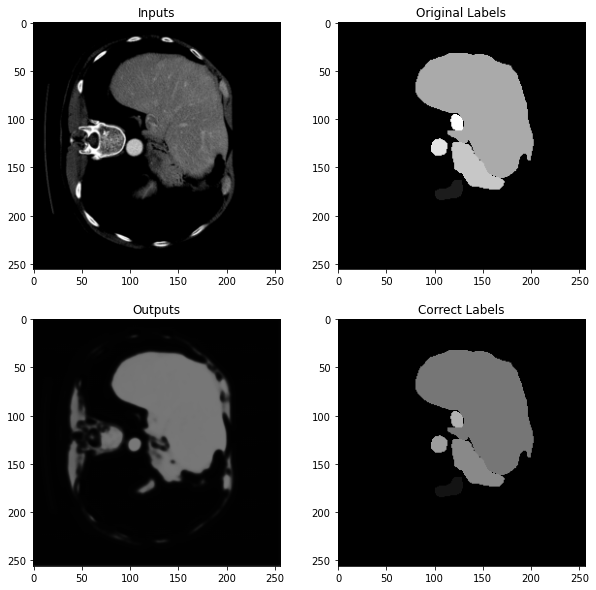


train epoch 12 batch 20 -- Loss: 1.040025 -- Accuracy 0.416222
train epoch 12 batch 40 -- Loss: 1.247050 -- Accuracy 0.351517
train epoch 12 batch 60 -- Loss: 1.471524 -- Accuracy 0.257047
train epoch 12 batch 80 -- Loss: 1.150484 -- Accuracy 0.414927
Epoch 12 avg train loss: 1.182198  acc: 0.3646049499511719
0.99941254
0.017823314
0.0018362373
0.0026948983
0.00062397245
0.0002872564
0.16731715
0.01274941
0.0013412321
0.0016144
0.0012053587
0.0018388871
0.00024802273
0.00029200033


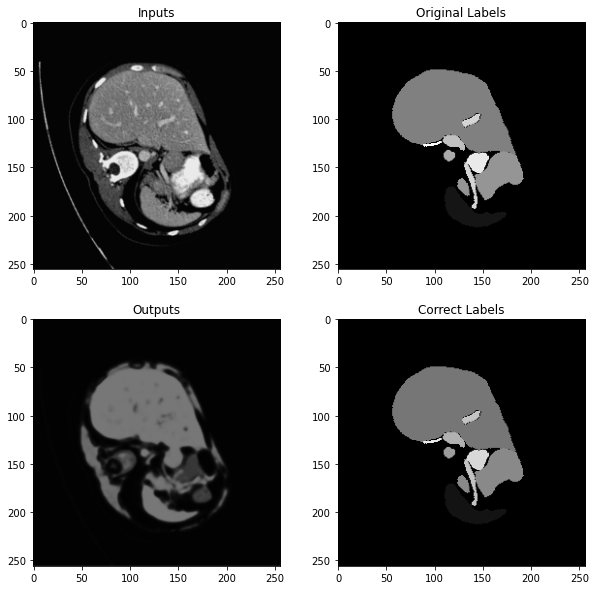

Epoch 12 avg val loss: 1.026021  acc: 0.44753989577293396
0.9997157
0.006017607
0.0008421521
0.001211195
0.00034273564
0.00013676111
0.047718883
0.0066962996
0.0006861089
0.0007318712
0.0005714767
0.0009518459
0.000111698566
0.00013472256


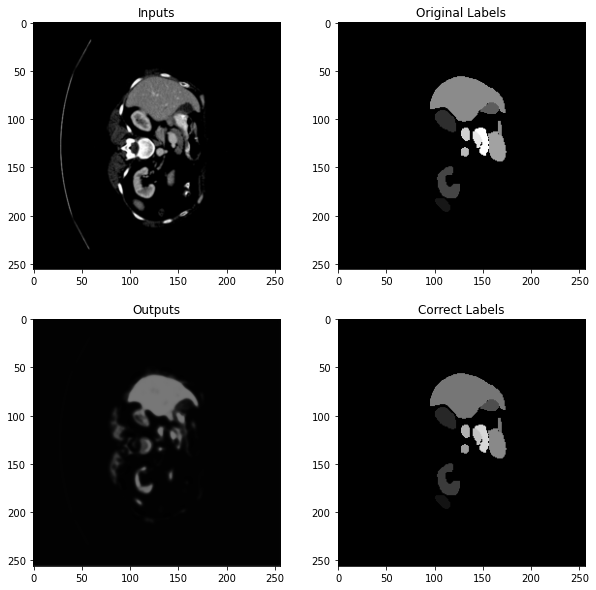


train epoch 13 batch 20 -- Loss: 1.397990 -- Accuracy 0.246410
train epoch 13 batch 40 -- Loss: 1.118674 -- Accuracy 0.314773
train epoch 13 batch 60 -- Loss: 1.219557 -- Accuracy 0.403871
train epoch 13 batch 80 -- Loss: 1.158190 -- Accuracy 0.392236
Epoch 13 avg train loss: 1.202978  acc: 0.35033902525901794
0.99963284
0.008360498
0.0009589085
0.0013753091
0.0004063546
0.00016082563
0.07527313
0.0098253675
0.00080543006
0.0009181373
0.0007037055
0.00104474
0.00013409172
0.00015819841


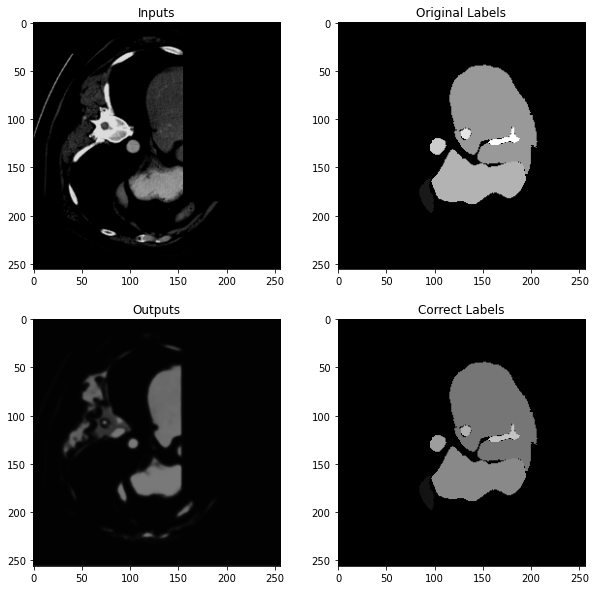

Epoch 13 avg val loss: 1.063031  acc: 0.4399700164794922
0.99937534
0.022592407
0.0014962698
0.002094722
0.0005333974
0.00024576572
0.18293604
0.011543033
0.0011442724
0.0016419432
0.0010473548
0.0016801347
0.0002066601
0.00023228663


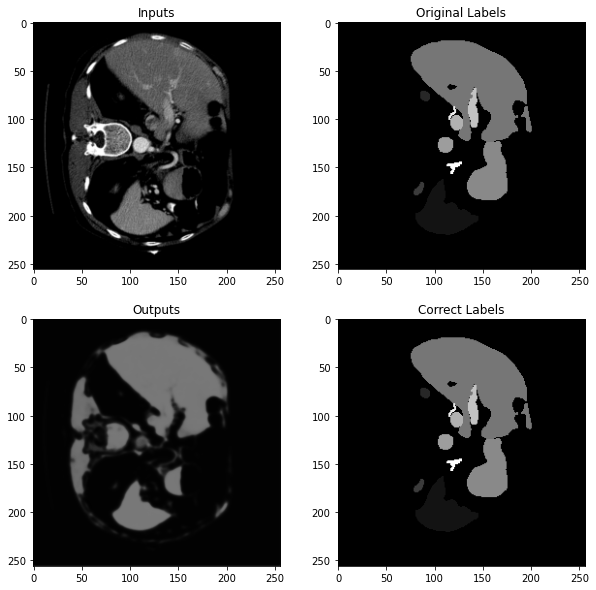


train epoch 14 batch 20 -- Loss: 1.216233 -- Accuracy 0.347940
train epoch 14 batch 40 -- Loss: 1.216002 -- Accuracy 0.361057
train epoch 14 batch 60 -- Loss: 1.370335 -- Accuracy 0.246686
train epoch 14 batch 80 -- Loss: 1.277958 -- Accuracy 0.266799
Epoch 14 avg train loss: 1.186742  acc: 0.3605819642543793
0.9995244
0.010294806
0.001170478
0.0016360226
0.00044127082
0.00018796675
0.07186688
0.007654565
0.0009039016
0.0010821448
0.0007949052
0.0012669348
0.00015167805
0.00017853215


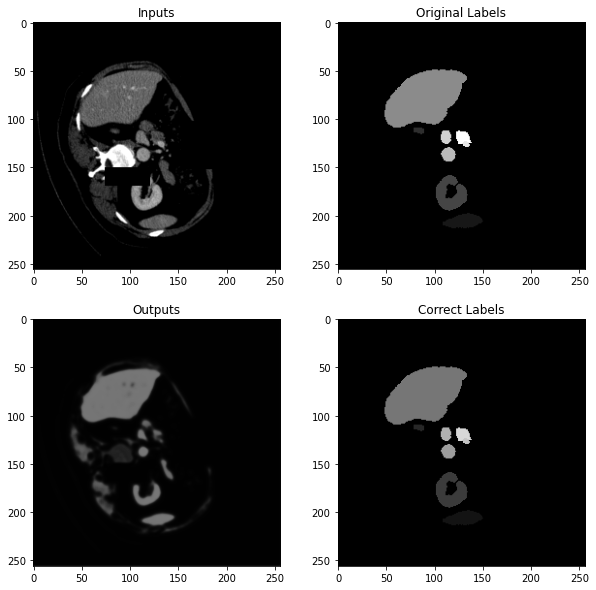

Epoch 14 avg val loss: 1.017545  acc: 0.44912999868392944
0.9995418
0.010371887
0.0011221805
0.0015459117
0.00042321792
0.00018241107
0.07015339
0.0067589595
0.00086171174
0.0010462127
0.0007613414
0.0012185213
0.00014775839
0.00017246137


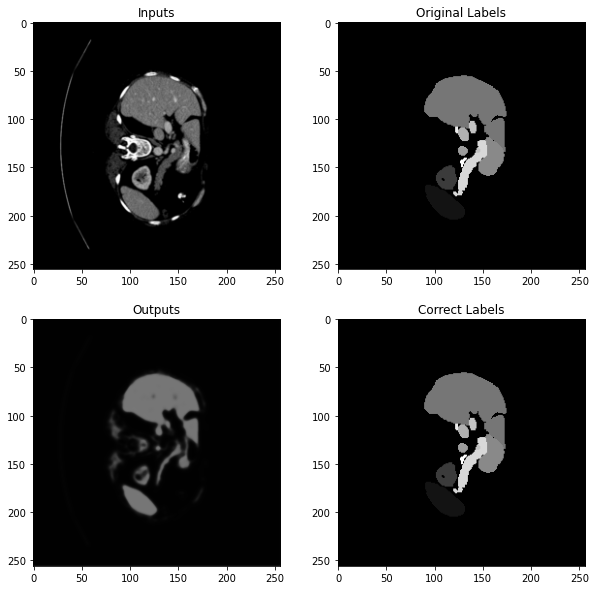


train epoch 15 batch 20 -- Loss: 1.261657 -- Accuracy 0.387385
train epoch 15 batch 40 -- Loss: 1.098283 -- Accuracy 0.439820
train epoch 15 batch 60 -- Loss: 1.307506 -- Accuracy 0.405107
train epoch 15 batch 80 -- Loss: 1.310696 -- Accuracy 0.369154
Epoch 15 avg train loss: 1.180271  acc: 0.36476930975914
0.9997682
0.0035144622
0.00051283767
0.00067769585
0.00021579882
7.4794094e-05
0.023347257
0.0041930736
0.0004074367
0.00044623893
0.0003256107
0.0006342875
5.615987e-05
7.0570946e-05


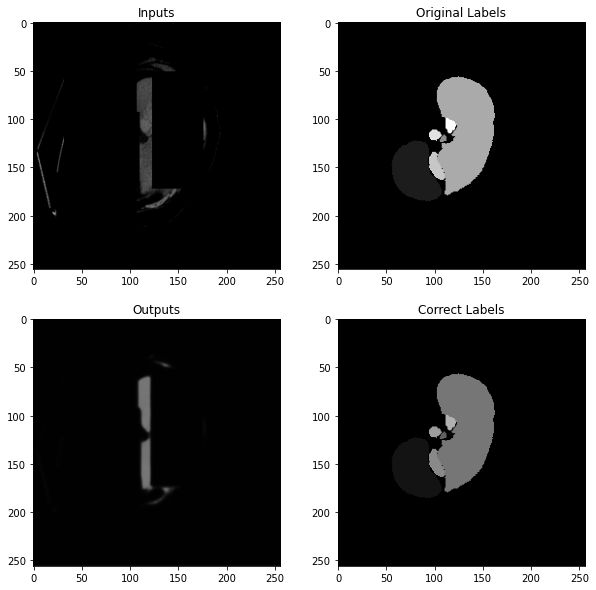

Epoch 15 avg val loss: 1.057725  acc: 0.4420638084411621
0.99948776
0.014688738
0.0011822378
0.0016317021
0.000398715
0.00017398634
0.121348515
0.007827016
0.00085480284
0.0011666256
0.00076000614
0.0013489921
0.00014388029
0.00016634403


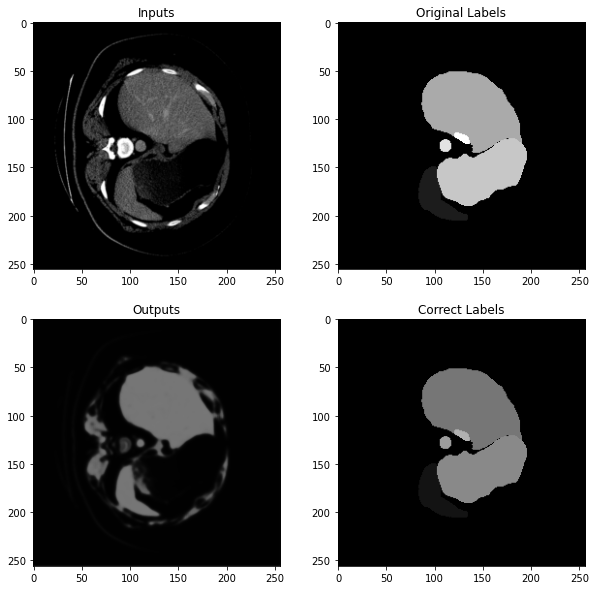


train epoch 16 batch 20 -- Loss: 1.120221 -- Accuracy 0.411629
train epoch 16 batch 40 -- Loss: 0.944651 -- Accuracy 0.486944
train epoch 16 batch 60 -- Loss: 1.271883 -- Accuracy 0.350119
train epoch 16 batch 80 -- Loss: 1.210039 -- Accuracy 0.334160
Epoch 16 avg train loss: 1.168369  acc: 0.3709387481212616
0.9991963
0.017352058
0.0019310062
0.002732032
0.00068823335
0.0003316589
0.09899302
0.012155437
0.0014388599
0.0017845713
0.0013392563
0.0020230373
0.0002921638
0.00032792875


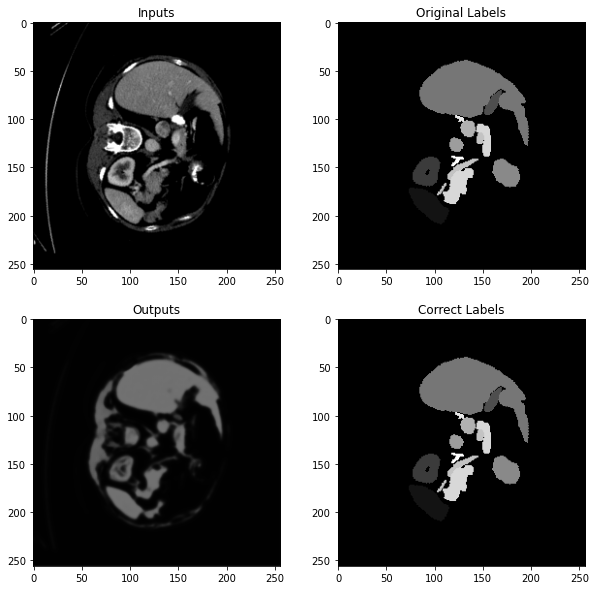

Epoch 16 avg val loss: 1.052850  acc: 0.4112173914909363
0.9990468
0.029411219
0.002205557
0.0031371424
0.00065676105
0.00033762323
0.19222492
0.013086824
0.0015406976
0.002286555
0.0014770407
0.002416109
0.00029852486
0.00033143922


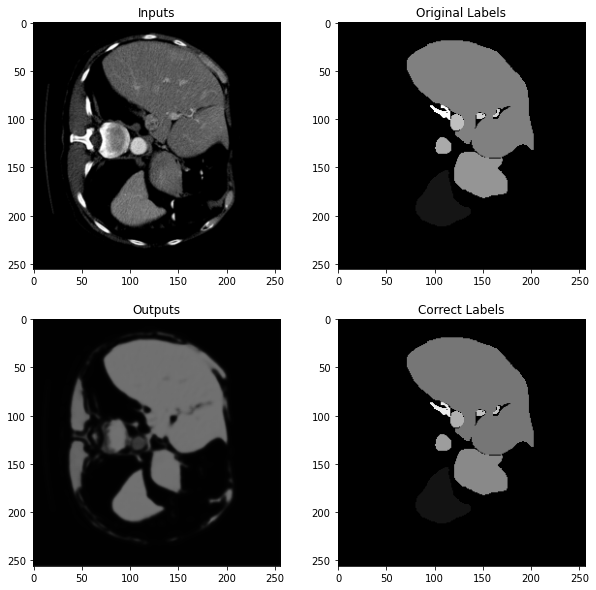


train epoch 17 batch 20 -- Loss: 1.187103 -- Accuracy 0.392242
train epoch 17 batch 40 -- Loss: 1.221131 -- Accuracy 0.346825
train epoch 17 batch 60 -- Loss: 1.252651 -- Accuracy 0.232364
train epoch 17 batch 80 -- Loss: 1.210648 -- Accuracy 0.281578
Epoch 17 avg train loss: 1.198464  acc: 0.34853726625442505
0.99937207
0.013320747
0.0012268693
0.0015539592
0.00049076404
0.00019432517
0.09059921
0.009863829
0.0009523157
0.0011606672
0.0008224168
0.0013621753
0.00015820915
0.00018588346


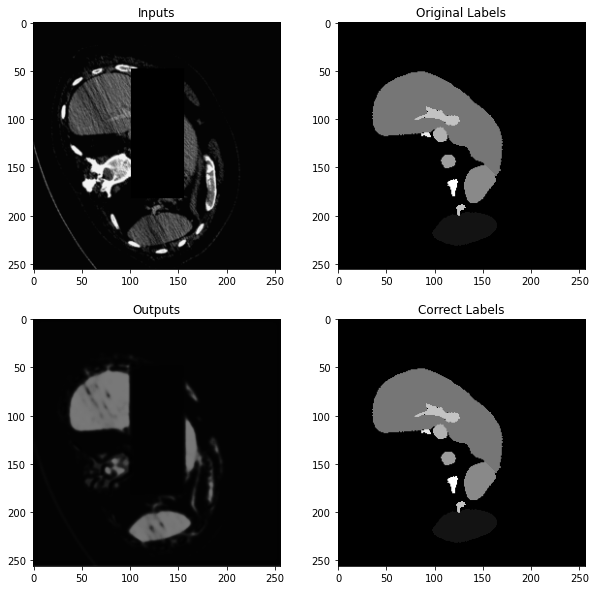

Epoch 17 avg val loss: 1.081782  acc: 0.4343310296535492
0.99922526
0.028429333
0.0016038858
0.0021720089
0.00054559414
0.00024802316
0.1780948
0.011186672
0.0011797562
0.0016185862
0.0010801556
0.001707633
0.00020997222
0.00023659792


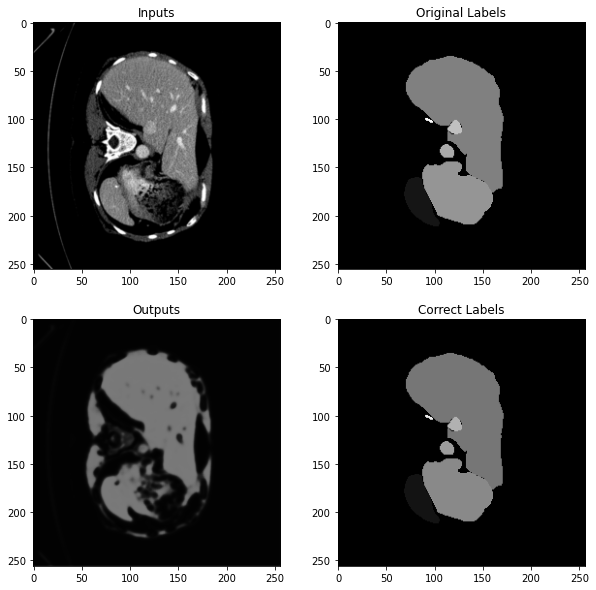


train epoch 18 batch 20 -- Loss: 1.384579 -- Accuracy 0.287046
train epoch 18 batch 40 -- Loss: 1.308250 -- Accuracy 0.341843


In [0]:
if __name__ == "__main__":
  dim = 2
  
  try:
      torch.multiprocessing.set_start_method('spawn')    
  except:
      pass

  # CUDA for PyTorch
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda:0" if use_cuda else "cpu")
  torch.cuda.empty_cache()   
  
  #%% Create Model
  #try:
  #  model
  #except:
  #  model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
  #  in_channels=3, out_channels=1, init_features=32, pretrained=True)
  
  model = UNet()
  print ("Model loaded.")
  model = model.to(device)

  #%% Create datasets
  try:
      dataset
  except:
      dataset = Nifti_Dataset(mode = "train", dim = dim)
      print("Loaded dataset on dimension {}".format(dim))

  start_epoch = -1
  num_epochs = 200

  loss = Dice_Loss()
  loss2 = nn.BCELoss()

  optimizer = optim.SGD(model.parameters(), lr= 0.1,momentum = 0.1)    
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.333333, mode = "max", patience = 3,verbose=True)

  #checkpoint = "/content/drive/My Drive/Colab Notebooks/Segmentation/checkpoints/UNET11_foreground_e22.pt"
  checkpoint = "/content/drive/My Drive/Colab Notebooks/Segmentation/checkpoints/UNET114_slices_e19.pt"
  #checkpoint = "/content/drive/My Drive/Colab Notebooks/Segmentation/checkpoints/possibly_worth_saving2.pt"

  if checkpoint:
    model,optimizer,_,all_losses,all_accs = load_model(checkpoint,model, optimizer)
    print("Reloaded checkpoint {}.".format(checkpoint))
  if True:    
  # train model
      print("Beginning training on {}.".format(device))
      model,all_losses,all_accs = train_model(model,
                                              optimizer,
                                              scheduler,
                                              loss,
                                              loss2,
                                              dataset,
                                              device,
                                              num_epochs, 
                                              start_epoch+1,
                                              all_losses= None,
                                              all_accs= None,
                                              refactor_mode = "organ_slices")


  torch.cuda.empty_cache()  

In [0]:
del  model  